In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Bernoulli
from torch.autograd import Variable
from itertools import count
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import gym.spaces
import gym
import pdb

In [2]:
class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()

        self.fc1 = nn.Linear(4, 24)
        self.fc2 = nn.Linear(24, 36)
        self.fc3 = nn.Linear(36, 1)  # Prob of Left

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [3]:
def main():

    # Plot duration curve: 
    # From http://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
    episode_durations = []
    def plot_durations():
        plt.figure(2)
        plt.clf()
        durations_t = torch.FloatTensor(episode_durations)
        plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy())
        # Take 100 episode averages and plot them too
        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())

        display.clear_output(wait=True)
        plt.pause(0.001)  # pause a bit so that plots are updated

    # Parameters
    num_episode = 5000
    batch_size = 5
    learning_rate = 0.01
    gamma = 0.99

    env = gym.make('CartPole-v0')
    policy_net = PolicyNet()
    optimizer = torch.optim.RMSprop(policy_net.parameters(), lr=learning_rate)

    # Batch History
    state_pool = []
    action_pool = []
    reward_pool = []
    steps = 0


    for e in range(num_episode):

        state = env.reset()
        state = torch.from_numpy(state).float()
        state = Variable(state)
        env.render(mode='rgb_array')

        for t in count():

            probs = policy_net(state)
            m = Bernoulli(probs)
            action = m.sample()

            action = action.data.numpy().astype(int)[0]
            next_state, reward, done, _ = env.step(action)
            env.render(mode='rgb_array')

            # To mark boundarys between episodes
            if done:
                reward = 0

            state_pool.append(state)
            action_pool.append(float(action))
            reward_pool.append(reward)

            state = next_state
            state = torch.from_numpy(state).float()
            state = Variable(state)

            steps += 1

            if done:
                episode_durations.append(t + 1)
                plot_durations()
                break

        # Update policy
        if e > 0 and e % batch_size == 0:

            # Discount reward
            running_add = 0
            for i in reversed(range(steps)):
                if reward_pool[i] == 0:
                    running_add = 0
                else:
                    running_add = running_add * gamma + reward_pool[i]
                    reward_pool[i] = running_add

            # Normalize reward
            reward_mean = np.mean(reward_pool)
            reward_std = np.std(reward_pool)
            for i in range(steps):
                reward_pool[i] = (reward_pool[i] - reward_mean) / reward_std

            # Gradient Desent
            optimizer.zero_grad()

            for i in range(steps):
                state = state_pool[i]
                action = Variable(torch.FloatTensor([action_pool[i]]))
                reward = reward_pool[i]

                probs = policy_net(state)
                m = Bernoulli(probs)
                loss = -m.log_prob(action) * reward  # Negtive score function x reward
                loss.backward()

            optimizer.step()

            state_pool = []
            action_pool = []
            reward_pool = []
            steps = 0

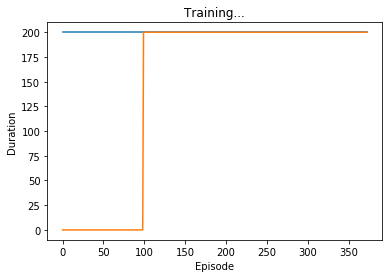

In [ ]:
main()